In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
import pickle
import time
import json
import gc

In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

from numpy.random import seed
seed(101)


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

data = pd.read_csv('/home/suresh/Profile-Areas/Project3/DataSet/dataset_labels.csv')
train_path = '/home/suresh/Profile-Areas/Project3/DataSet/400X/'
test_path = '/home/suresh/Profile-Areas/Project3/DataSet/test/'
# quick look at the label stats
print(data.head())
data['class[B=0,M=1]'].value_counts()


                               id  class[B=0,M=1]
0  SOB_B_A-14-22549AB-400-030.png               0
1  SOB_B_A-14-22549AB-400-023.png               0
2  SOB_B_A-14-22549AB-400-013.png               0
3  SOB_B_A-14-22549AB-400-015.png               0
4  SOB_B_A-14-22549AB-400-003.png               0


1    1232
0     588
Name: class[B=0,M=1], dtype: int64

In [5]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

/home/suresh/Profile-Areas/Project3/DataSet/400X/SOB_M_DC-14-14946-400-027.png
/home/suresh/Profile-Areas/Project3/DataSet/400X/SOB_M_DC-14-4364-400-008.png
/home/suresh/Profile-Areas/Project3/DataSet/400X/SOB_M_DC-14-8168-400-002.png
/home/suresh/Profile-Areas/Project3/DataSet/400X/SOB_M_DC-14-16448-400-013.png
/home/suresh/Profile-Areas/Project3/DataSet/400X/SOB_M_DC-14-14946-400-007.png


Text(0, 0.5, 'Malign/Positive Tumor tissue samples')

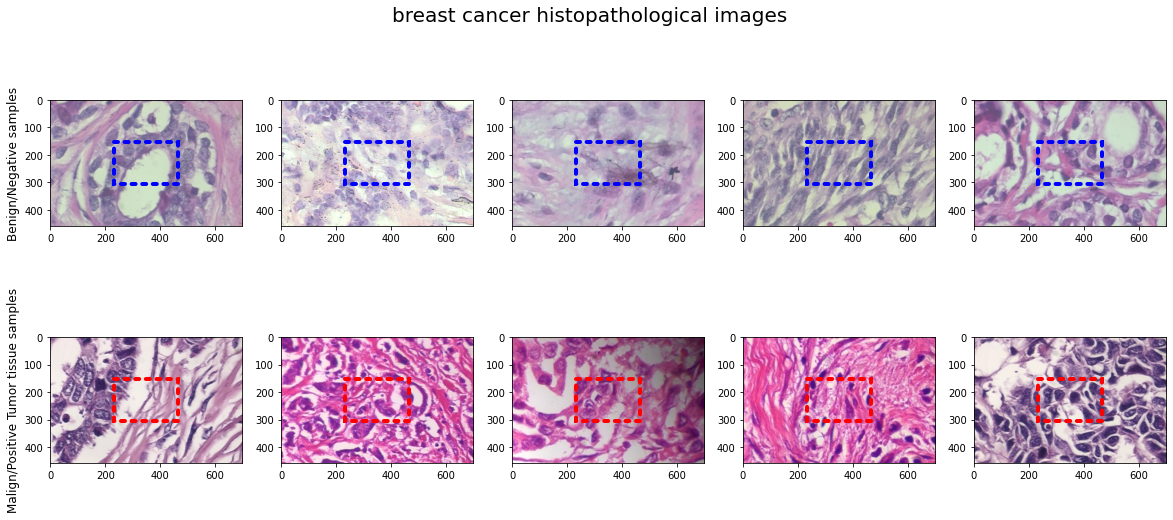

In [6]:
# random sampling
shuffled_data = shuffle(data)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('breast cancer histopathological images',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['class[B=0,M=1]'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path))
    # Create a Rectangle patch
    box = patches.Rectangle((233,153),233,153,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Benign/Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['class[B=0,M=1]'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    print(path)
    ax[1,i].imshow(readImage(path))
    # Create a Rectangle patch
    box = patches.Rectangle((233,153),233,153,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Malign/Positive samples', size='large')


In [7]:
y = shuffled_data['class[B=0,M=1]']

In [8]:
#df_train, df_val = train_test_split(shuffled_data, test_size=0.20, random_state=101, stratify=y)
df_train, df_val, test = np.split(shuffled_data.sample(frac=1, random_state=41), [int(.7*len(shuffled_data)), int(.85*len(shuffled_data))])

In [9]:
print('Dataset size', shuffled_data.shape)
print('train data size',df_train.shape)
print(df_val.shape)
print(test.shape)

Dataset size (1820, 2)
train data size (1274, 2)
(273, 2)
(273, 2)


In [10]:
print(df_train['class[B=0,M=1]'].value_counts())
print(df_val['class[B=0,M=1]'].value_counts())
print(test['class[B=0,M=1]'].value_counts())

1    875
0    399
Name: class[B=0,M=1], dtype: int64
1    178
0     95
Name: class[B=0,M=1], dtype: int64
1    179
0     94
Name: class[B=0,M=1], dtype: int64


In [11]:
# Create a new directory
base_dir = '/home/suresh/Profile-Areas/Project3/DataSet/base_dir'
shutil.rmtree(base_dir)

In [12]:

if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [13]:
#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue

# val_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue



# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
if not os.path.exists(val_dir):
    os.mkdir(val_dir)
#test_dir
test_dir = os.path.join(base_dir, 'test_dir')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'B')
if not os.path.exists(no_tumor_tissue):
    os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'M')
if not os.path.exists(has_tumor_tissue):
    os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'B')
if not os.path.exists(no_tumor_tissue):
    os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'M')
if not os.path.exists(has_tumor_tissue):
    os.mkdir(has_tumor_tissue)
    
# create new folders inside test_dir
no_tumor_tissue = os.path.join(test_dir, 'B')
if not os.path.exists(no_tumor_tissue):
    os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(test_dir, 'M')
if not os.path.exists(has_tumor_tissue):
    os.mkdir(has_tumor_tissue)

In [14]:
# check that the folders have been created
os.listdir(base_dir+'/train_dir')

['B', 'M']

In [15]:
# Set the id as the index in df_data
shuffled_data.set_index('id', inplace=True)

In [16]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])
test_list=list(test['id'])

In [17]:
# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image 
    # get the label for a certain image
    target = shuffled_data.loc[image,'class[B=0,M=1]']
    
    # these must match the folder names
    if target == 0:
        label = 'B'
    if target == 1:
        label = 'M'
    
    # source path to image
    src = os.path.join('/home/suresh/Profile-Areas/Project3/DataSet/400X', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
    # get the label for a certain image
    target = shuffled_data.loc[image,'class[B=0,M=1]']
    
    # these must match the folder names
    if target == 0:
        label = 'B'
    if target == 1:
        label = 'M'
    

    # source path to image
    src = os.path.join('/home/suresh/Profile-Areas/Project3/DataSet/400X', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

# Transfer the test images

for image in test_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
    # get the label for a certain image
    target = shuffled_data.loc[image,'class[B=0,M=1]']
    
    # these must match the folder names
    if target == 0:
        label = 'B'
    if target == 1:
        label = 'M'
    

    # source path to image
    src = os.path.join('/home/suresh/Profile-Areas/Project3/DataSet/400X', fname)
    # destination path to image
    dst = os.path.join(test_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [18]:
# check how many train images we have in each folder

print(len(os.listdir('/home/suresh/Profile-Areas/Project3/DataSet/base_dir/train_dir/B')))
print(len(os.listdir('/home/suresh/Profile-Areas/Project3/DataSet/base_dir/train_dir/M')))

399
875


In [19]:
train_path = '/home/suresh/Profile-Areas/Project3/DataSet/base_dir/train_dir'
valid_path = '/home/suresh/Profile-Areas/Project3/DataSet/base_dir/val_dir'
test_path =  '/home/suresh/Profile-Areas/Project3/DataSet/base_dir/test_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 1
val_batch_size = 1


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [20]:
def data_gen(IMAGE_SIZE_W = 300,IMAGE_SIZE_H=300,IMAGE_CHANNELS = 3):
    #IMAGE_SIZE_W = 300
    #IMAGE_SIZE_H=300

    datagen = ImageDataGenerator(rescale=1.0/255, #zoom_range=0.2,  # set range for random zoom
            #rotation_range = 90,
            #horizontal_flip=True,  # randomly flip images
            #vertical_flip=True, 
            )  # randomly flip images)

    train_gen = datagen.flow_from_directory(train_path,
                                            target_size=(IMAGE_SIZE_W,IMAGE_SIZE_H),
                                            batch_size=train_batch_size,
                                            class_mode='categorical')

    val_gen = datagen.flow_from_directory(valid_path,
                                            target_size=(IMAGE_SIZE_W,IMAGE_SIZE_H),
                                            batch_size=val_batch_size,
                                            class_mode='categorical')

    # Note: shuffle=False causes the test dataset to not be shuffled
    test_gen = datagen.flow_from_directory(test_path,
                                            target_size=(IMAGE_SIZE_W,IMAGE_SIZE_H),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False)
    return train_gen,val_gen,test_gen

In [21]:
def proposed_model():
    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128

    dropout_conv = 0.3
    dropout_dense = 0.3


    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (150, 150, 3)))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(2, activation = "softmax"))

    model.summary()
    model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    filepath = "model.h5" #the file path where we need to save the model
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                                 save_best_only=True, mode='max')

    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                       verbose=1, mode='max', min_lr=0.00001)


    callbacks_list = [checkpoint, reduce_lr]
    train_gen,val_gen,test_gen=data_gen(IMAGE_SIZE_W = 150,IMAGE_SIZE_H=150,IMAGE_CHANNELS = 3)
    history1 = model.fit(train_gen, steps_per_epoch=train_steps, 
                        validation_data=val_gen,
                        validation_steps=val_steps,
                        epochs=20, verbose=1,
                       callbacks=callbacks_list)
    
    with open('history1.json', 'w') as f:
        json.dump(str(history1.history), f)
    history_df = pd.DataFrame(history1.history)
    #training accuracy vs Validation Accuracy Plot
    history_df[['accuracy', 'val_accuracy']].plot()
    # Train Loss vs Validation Loss plot
    history_df[['loss', 'val_loss']].plot()
    return model

In [ ]:

#call proposed model
model=proposed_model()

In [22]:
def build_model(backbone, lr=1e-4):
    
    model = Sequential()
    model.add(backbone)
    
    #model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    #model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    #model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    #model.add(MaxPooling2D(pool_size = pool_size))
    #model.add(Dropout(dropout_conv))

    #model.add(Flatten())
    #model.add(Dense(256, activation = "relu"))
    #model.add(Dropout(dropout_dense))
    #model.add(Dense(2, activation = "softmax"))

    #model.summary()
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    #using resnet prettrained model

    
    return model

In [23]:
def pretrained_model_stack():
    K.clear_session()
    gc.collect()

    resnet = DenseNet201(
        weights='imagenet',
        include_top=False,
        input_shape=(96,96,3)
    )
    model = build_model(resnet ,lr = 0.01)
    model.summary()
    # Learning Rate Reducer
    learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                      verbose=1,factor=0.2, min_lr=1e-7)

    # Checkpoint
    filepath="Latest1_weights.best.hdf5" #best model file name
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    train_gen,val_gen,test_gen=data_gen(IMAGE_SIZE_W = 96,IMAGE_SIZE_H=96,IMAGE_CHANNELS = 3)
    history2 = model.fit(train_gen,
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=val_gen,
                    validation_steps=val_steps, verbose=1,
    callbacks=[learn_control, checkpoint])
    with open('history2.json', 'w') as f:
        json.dump(str(history2.history), f)
    history_df = pd.DataFrame(history2.history)
    #training accuracy vs Validation Accuracy Plot
    history_df[['accuracy', 'val_accuracy']].plot()
    # Train Loss vs Validation Loss plot
    history_df[['loss', 'val_loss']].plot()
    return model

In [24]:
densenet_model=pretrained_model_stack()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________
Found 1274 images belonging to 2 classes.
Found 273 images belonging to 2 classes.
Found 273 images belo